In [173]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm

In [174]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [175]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [176]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


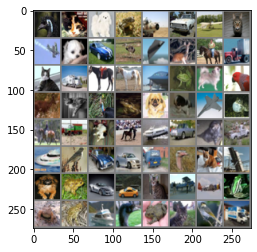

bird  cat   dog   frog  plane car   plane cat   plane dog   car   bird  plane deer  horse truck cat   truck horse horse plane frog  dog   bird  deer  cat   bird  frog  dog   dog   plane frog  horse truck cat   horse ship  car   cat   truck ship  bird  car   car   truck bird  cat   truck dog   frog  car   car   cat   plane plane frog  frog  frog  ship  bird  frog  cat   bird  truck


In [177]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [178]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.sigmoid(self.conv1(x)))
        x = self.pool(F.sigmoid(self.conv2(x)))
        x = self.pool(F.sigmoid(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.sigmoid(self.fc1(x)))
        x = self.dropout(F.sigmoid(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [179]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.001,momentum = 0):
    history = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
    return history, end

In [180]:
begin = time.time()
history, end = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

  0%|          | 0/657 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 657/657 [00:11<00:00, 57.91it/s]


Epoch [0], Time taken :13.2368, train_loss : 2.3468, train_acc: 0.1005, val_loss: 2.3452, val_acc: 0.0914


100%|██████████| 657/657 [00:10<00:00, 60.88it/s]


Epoch [1], Time taken :12.7317, train_loss : 2.3398, train_acc: 0.0979, val_loss: 2.3353, val_acc: 0.1061


100%|██████████| 657/657 [00:11<00:00, 58.94it/s]


Epoch [2], Time taken :12.9610, train_loss : 2.3367, train_acc: 0.0987, val_loss: 2.3340, val_acc: 0.0994


100%|██████████| 657/657 [00:11<00:00, 58.19it/s]


Epoch [3], Time taken :13.5478, train_loss : 2.3352, train_acc: 0.0973, val_loss: 2.3285, val_acc: 0.1037


100%|██████████| 657/657 [00:10<00:00, 63.81it/s]


Epoch [4], Time taken :12.1496, train_loss : 2.3302, train_acc: 0.1009, val_loss: 2.3269, val_acc: 0.1005


100%|██████████| 657/657 [00:10<00:00, 61.30it/s]


Epoch [5], Time taken :12.4910, train_loss : 2.3291, train_acc: 0.0988, val_loss: 2.3289, val_acc: 0.1020


100%|██████████| 657/657 [00:09<00:00, 66.07it/s]


Epoch [6], Time taken :11.8326, train_loss : 2.3265, train_acc: 0.1010, val_loss: 2.3262, val_acc: 0.1026


100%|██████████| 657/657 [00:09<00:00, 66.00it/s]


Epoch [7], Time taken :11.9759, train_loss : 2.3229, train_acc: 0.1046, val_loss: 2.3282, val_acc: 0.1036


100%|██████████| 657/657 [00:10<00:00, 60.57it/s]


Epoch [8], Time taken :12.6354, train_loss : 2.3234, train_acc: 0.1006, val_loss: 2.3249, val_acc: 0.0944


100%|██████████| 657/657 [00:09<00:00, 66.66it/s]


Epoch [9], Time taken :11.7008, train_loss : 2.3224, train_acc: 0.1009, val_loss: 2.3218, val_acc: 0.1016


100%|██████████| 657/657 [00:09<00:00, 66.87it/s]


Epoch [10], Time taken :11.6675, train_loss : 2.3208, train_acc: 0.1020, val_loss: 2.3200, val_acc: 0.0991


100%|██████████| 657/657 [00:10<00:00, 60.47it/s]


Epoch [11], Time taken :12.7458, train_loss : 2.3201, train_acc: 0.0994, val_loss: 2.3191, val_acc: 0.0988


100%|██████████| 657/657 [00:09<00:00, 66.24it/s]


Epoch [12], Time taken :11.9426, train_loss : 2.3194, train_acc: 0.0999, val_loss: 2.3221, val_acc: 0.0927


100%|██████████| 657/657 [00:09<00:00, 66.05it/s]


Epoch [13], Time taken :12.2829, train_loss : 2.3194, train_acc: 0.0985, val_loss: 2.3172, val_acc: 0.1025


100%|██████████| 657/657 [00:09<00:00, 65.72it/s]


Epoch [14], Time taken :11.7893, train_loss : 2.3172, train_acc: 0.1011, val_loss: 2.3180, val_acc: 0.1016


100%|██████████| 657/657 [00:10<00:00, 63.06it/s]


Epoch [15], Time taken :12.2861, train_loss : 2.3165, train_acc: 0.1010, val_loss: 2.3163, val_acc: 0.0969


100%|██████████| 657/657 [00:10<00:00, 60.74it/s]


Epoch [16], Time taken :12.5891, train_loss : 2.3155, train_acc: 0.0995, val_loss: 2.3131, val_acc: 0.1024


100%|██████████| 657/657 [00:09<00:00, 66.43it/s]


Epoch [17], Time taken :11.6658, train_loss : 2.3161, train_acc: 0.0992, val_loss: 2.3146, val_acc: 0.1004


100%|██████████| 657/657 [00:10<00:00, 64.78it/s]


Epoch [18], Time taken :11.9891, train_loss : 2.3154, train_acc: 0.0988, val_loss: 2.3138, val_acc: 0.0988


100%|██████████| 657/657 [00:10<00:00, 62.57it/s]


Epoch [19], Time taken :12.2603, train_loss : 2.3154, train_acc: 0.1003, val_loss: 2.3164, val_acc: 0.0990


100%|██████████| 657/657 [00:10<00:00, 65.55it/s]


Epoch [20], Time taken :11.9810, train_loss : 2.3132, train_acc: 0.1020, val_loss: 2.3109, val_acc: 0.1011


100%|██████████| 657/657 [00:10<00:00, 64.39it/s]


Epoch [21], Time taken :12.6995, train_loss : 2.3121, train_acc: 0.1023, val_loss: 2.3153, val_acc: 0.0944


100%|██████████| 657/657 [00:09<00:00, 65.80it/s]


Epoch [22], Time taken :12.0864, train_loss : 2.3136, train_acc: 0.0990, val_loss: 2.3139, val_acc: 0.0995


100%|██████████| 657/657 [00:09<00:00, 66.00it/s]


Epoch [23], Time taken :11.8793, train_loss : 2.3125, train_acc: 0.1001, val_loss: 2.3124, val_acc: 0.0965


100%|██████████| 657/657 [00:10<00:00, 61.57it/s]


Epoch [24], Time taken :12.4825, train_loss : 2.3134, train_acc: 0.1001, val_loss: 2.3104, val_acc: 0.1011


100%|██████████| 657/657 [00:10<00:00, 62.76it/s]


Epoch [25], Time taken :12.2493, train_loss : 2.3126, train_acc: 0.0975, val_loss: 2.3097, val_acc: 0.0999


100%|██████████| 657/657 [00:09<00:00, 67.32it/s]


Epoch [26], Time taken :11.5725, train_loss : 2.3125, train_acc: 0.1015, val_loss: 2.3116, val_acc: 0.1040


100%|██████████| 657/657 [00:10<00:00, 61.95it/s]


Epoch [27], Time taken :12.4052, train_loss : 2.3124, train_acc: 0.0986, val_loss: 2.3093, val_acc: 0.1031


100%|██████████| 657/657 [00:10<00:00, 65.37it/s]


Epoch [28], Time taken :11.8444, train_loss : 2.3111, train_acc: 0.0990, val_loss: 2.3106, val_acc: 0.1000


100%|██████████| 657/657 [00:10<00:00, 63.30it/s]


Epoch [29], Time taken :12.8980, train_loss : 2.3104, train_acc: 0.1003, val_loss: 2.3134, val_acc: 0.0954
Finished Training in 369.04839181900024secs


In [181]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

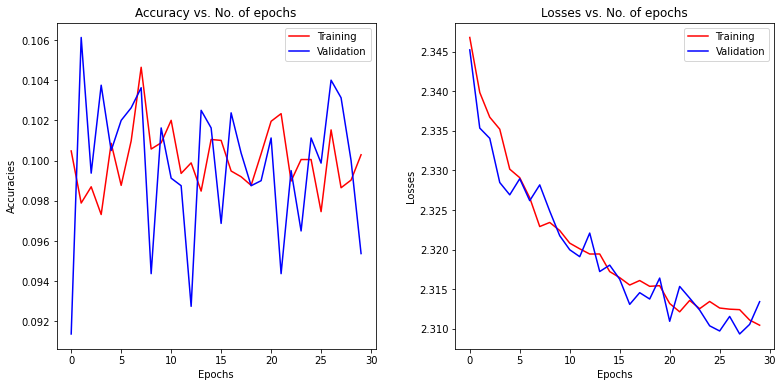

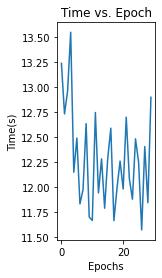

In [182]:
def plot_results(history):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(131)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(132)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(1,3,3)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
              
plot_results(history)

In [183]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [184]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 10 %


In [185]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 8.5 %
Accuracy for class: car   is 12.3 %
Accuracy for class: bird  is 8.6 %
Accuracy for class: cat   is 9.8 %
Accuracy for class: deer  is 9.1 %
Accuracy for class: dog   is 10.6 %
Accuracy for class: frog  is 11.6 %
Accuracy for class: horse is 11.6 %
Accuracy for class: ship  is 10.0 %
Accuracy for class: truck is 9.5 %
